### This notebook wIll be used for IBM Capstone homework segmenting and clustering neighbourhoods in Toronto using Foursquare API to explore neighbourhood data.

### PART 1 OF ASSIGNMENT

#### Using beautiful soup for scraping

In [124]:
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import re
from urllib.request import urlopen
import matplotlib.pyplot as plt

url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html = urlopen(url) 
soup = BeautifulSoup(html, 'html.parser')


In [42]:
def preprocess(text):
    
    """
        Function to extract only text before new line character due to duplicates appearing after newline
        
    """
    
    return re.search('.+', text).group()

In [3]:
tables = soup.find_all("table")

In [5]:
#Create array to hold the data we extract
Postal_Codes = []
Boroughs = []
Neighbourhoods = []

table = tables[0]


#Finding all rows os table, tag is tr

rows = table.find_all('tr')
    

#Looping through rows, an assigning each cell to appropriate column

for row in rows:
    cells = row.find_all('td')
        
        
    if len(cells) > 1:
            
        Postal_Code = cells[0]
        Postal_Codes.append(preprocess(Postal_Code.text))
            
        Borough = cells[1]
        Boroughs.append(preprocess(Borough.text))
            
        Neighbourhood = cells[2]
        Neighbourhoods.append(preprocess(Neighbourhood.text))
            
         

In [36]:
cad_post= pd.DataFrame(Boroughs, index= Postal_Codes, columns = ['Borough']).reset_index().\
rename(columns = {'index' : 'Postal Code'})

cad_post['Neighbourhood'] = Neighbourhoods

In [37]:
cad_post

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
175,M5Z,Not assigned,Not assigned
176,M6Z,Not assigned,Not assigned
177,M7Z,Not assigned,Not assigned
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


#### Pre-processing for submission format:

In [38]:
#Pre-process only cells with assigned Borough
cad_post = cad_post[cad_post['Borough'] != 'Not assigned'].reset_index(drop = True)

In [39]:
#Checking for Not assigned Neighbourhoods & replace with Boroughs if it exists
cad_post[cad_post['Neighbourhood'] == 'Not assigned']

,Postal Code,Borough,Neighbourhood


In [41]:
cad_post.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [45]:
cad_post.isnull().sum()

Postal Code      0
Borough          0
Neighbourhood    0
dtype: int64

In [44]:
cad_post.shape

(103, 3)

### PART 2 OF ASSIGNMENT

#### Merging lat/long location data to Postal Codes

In [47]:
coords = pd.read_csv('Geospatial_Coordinates.csv')

In [48]:
coords.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [50]:
cad_post = cad_post.merge(coords, how = 'left', on = 'Postal Code')

In [51]:
cad_post.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [ ]:
# import geocoder # import geocoder

# # initialize your variable to None
# lat_lng_coords = None

# # loop until you get the coordinates
# while(lat_lng_coords is None):
#   g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
#   lat_lng_coords = g.latlng

# latitude = lat_lng_coords[0]
# longitude = lat_lng_coords[1]

### PART 3 OF ASSIGNMENT

In [52]:
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### Use geopy library to get the latitude and longitude values of Toronto City.


In [56]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Selecting only Toronto City.

In [61]:
cad_post['Toronto'] = cad_post['Borough'].apply(lambda x: 1 if 'toronto' in x.lower() else 0)

In [63]:
#Selecting Toronto city in Canada
tor_cad = cad_post[cad_post['Toronto'] == 1].reset_index(drop = True)

In [64]:
tor_cad.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Toronto
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,1


In [88]:
tor_cad = tor_cad.drop(['Toronto'], axis = 1)

#### Create a map of Toronto with neighborhoods superimposed on top.


In [67]:
# create map of Toronto using latitude and longitude values
map_tor = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(tor_cad['Latitude'], tor_cad['Longitude'], tor_cad['Borough'], \
                                           tor_cad['Neighbourhood']):
    
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tor)  
    
map_tor

##### Define Foursquare Credentials

In [68]:
CLIENT_ID = 'YDT3RR2XQHDJOSCHBYWBEXKY01XM2VYPETBS2SFEEFJZOGAZ' # your Foursquare ID
CLIENT_SECRET = 'VGBGUOZFK34JJLF0RBMG3FRJZLOSWQYN0NG21Y3WAGY30FCD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YDT3RR2XQHDJOSCHBYWBEXKY01XM2VYPETBS2SFEEFJZOGAZ
CLIENT_SECRET:VGBGUOZFK34JJLF0RBMG3FRJZLOSWQYN0NG21Y3WAGY30FCD


In [69]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Explore Neighborhoods in Toronto


#### Let's create a function to extract all the venues (within our Foursquare query) in all the neighborhoods in Toronto


In [71]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [72]:
# type your answer here


toronto_venues = getNearbyVenues(names=tor_cad['Neighbourhood'],
                                   latitudes= tor_cad['Latitude'],
                                   longitudes= tor_cad['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


#### Let's check the size of the resulting dataframe

In [73]:
print(toronto_venues.shape)
toronto_venues.head()

(1618, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


Let's check how many venues were returned for each neighborhood

In [74]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,58,58,58,58,58,58
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,64,64,64,64,64,64
Christie,16,16,16,16,16,16
Church and Wellesley,80,80,80,80,80,80
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,33,33,33,33,33,33


#### Let's find out how many unique categories can be curated from all the returned venues


In [75]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 235 uniques categories.


### Analyze Each Neighborhood

In [76]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [77]:
toronto_onehot.shape

(1618, 235)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [78]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,Berczy Park,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.00,0.017241,0.000000,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
2,"Business reply mail Processing Centre, South C...",0.062500,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0000,0.0000,0.0625,0.0625,0.0625,0.125,0.1875,0.125,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
4,Central Bay Street,0.015625,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.00,0.015625,0.000000,0.000000,0.015625
5,Christie,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
6,Church and Wellesley,0.025000,0.0125,0.0125,0.0000,0.0000,0.0000,0.000,0.0000,0.000,...,0.012500,0.0125,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.012500,0.000000
7,"Commerce Court, Victoria Hotel",0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.010000
8,Davisville,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,...,0.000000,0.0000,0.000000,0.030303,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
9,Davisville North,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000


#### Let's confirm the new size

In [79]:
toronto_grouped.shape

(39, 235)

#### Let's print each neighborhood along with the top 5 most common venues

In [80]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
          venue  freq
0   Coffee Shop  0.09
1  Cocktail Bar  0.05
2      Beer Bar  0.03
3      Pharmacy  0.03
4        Bakery  0.03


----Brockton, Parkdale Village, Exhibition Place----
                    venue  freq
0                    Café  0.13
1             Coffee Shop  0.09
2          Breakfast Spot  0.09
3                     Gym  0.04
4  Furniture / Home Store  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0    Light Rail Station  0.12
1           Yoga Studio  0.06
2         Auto Workshop  0.06
3  Gym / Fitness Center  0.06
4         Garden Center  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0   Airport Service  0.19
1    Airport Lounge  0.12
2  Airport Terminal  0.12
3  Sculpture Garden  0.06
4   Harbor / Marina  0.06


----Central Bay Street----
                venue  f

#### Let's put that into a _pandas_ dataframe


First, let's write a function to sort the venues in descending order.

In [81]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [109]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Beer Bar,Farmers Market,Pharmacy,Cheese Shop,Bakery,Restaurant,Seafood Restaurant,Butcher
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Grocery Store,Bakery,Bar,Italian Restaurant,Restaurant,Climbing Gym,Burrito Place
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Yoga Studio,Auto Workshop,Gym / Fitness Center,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Comic Shop,Pizza Place
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Airport Lounge,Harbor / Marina,Sculpture Garden,Plane,Rental Car Location,Boat or Ferry,Bar,Airport Gate
4,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Burger Joint,Salad Place,Bubble Tea Shop,Thai Restaurant,Ramen Restaurant,Portuguese Restaurant


## Cluster Neighborhoods

Run _k_-means to cluster the neighborhood into clusters.


In [130]:
list(results.values())

[2.983836066953821,
 2.362125604554827,
 2.107954728240666,
 1.87907486805339,
 1.69157486805339,
 1.4454225955627744,
 1.3368589875500196,
 1.1728675014433632,
 1.1028604783406206]

Text(0, 0.5, 'SSE')

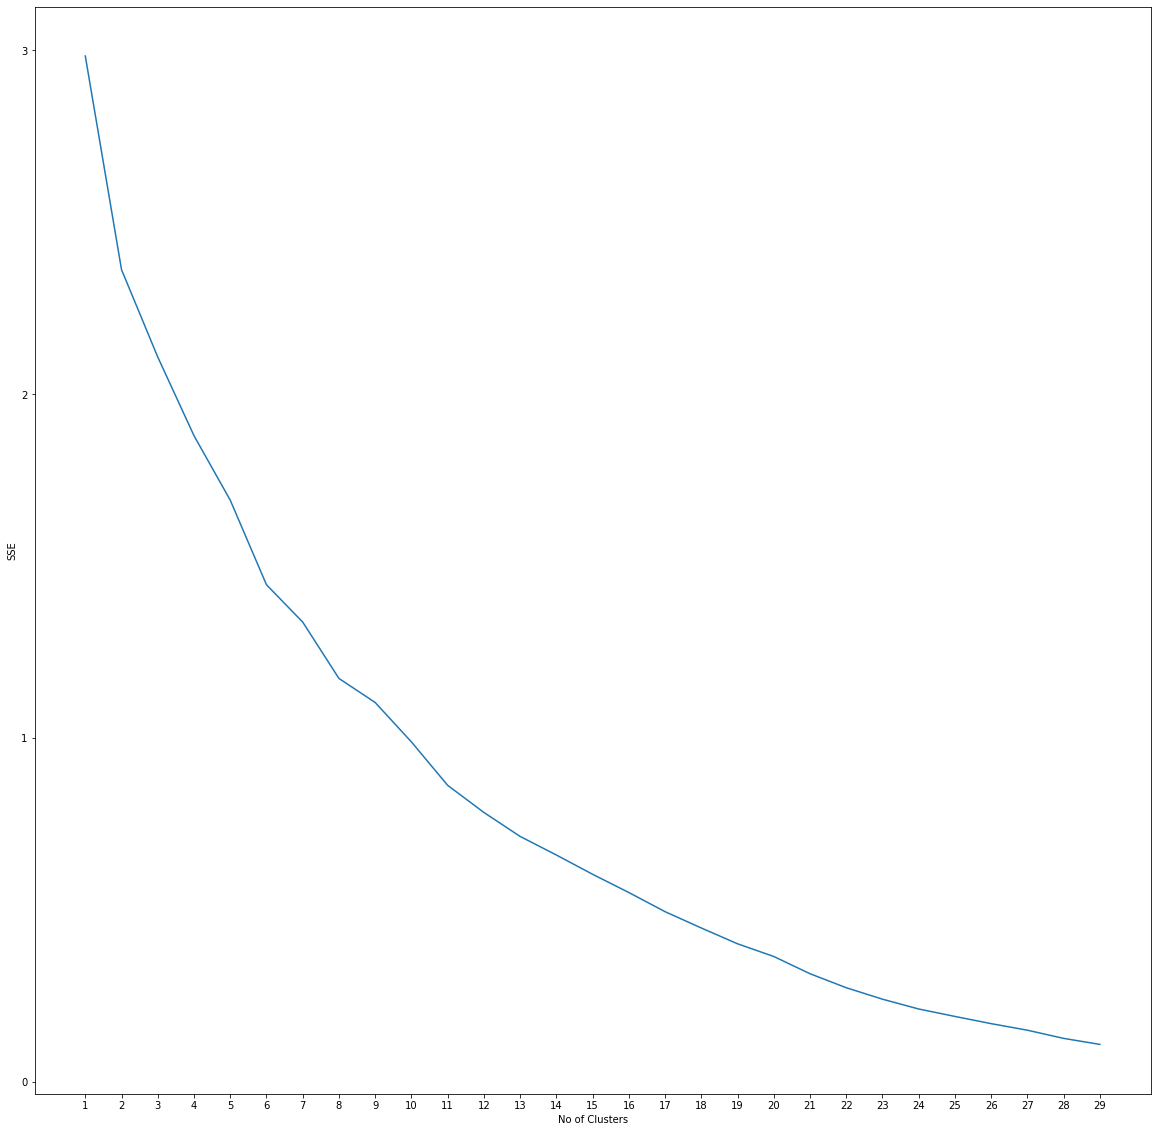

In [148]:
#Elbow method to determine number of clusters

results = {}

for k in range(1, 30):
    
    toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters= k, random_state=0).fit(toronto_grouped_clustering)
    
    SSE = kmeans.inertia_
    
    results[k] = SSE
    
    
plt.figure(figsize = (20, 20))

plt.xticks(range(1, 30))

plt.yticks(range(0, 4))
    
plt.plot(list(results.keys()), list(results.values()))

plt.xlabel('No of Clusters')

plt.ylabel('SSE')


    
    


From the elbow curve, we observe optimal No of Clusters of 11, where the loss only decreases by about 0.5 beyond that point

In [140]:
# set number of clusters
kclusters = 11

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:11] 

array([ 1,  1,  8,  9,  1,  7,  1,  1,  1, 10,  1])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [141]:
tor_cad.rename(columns = {'Neighbourhood' : 'Neighborhood'}, inplace = True)

In [142]:
tor_cad

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031
5,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
6,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
7,M6G,Downtown Toronto,Christie,43.669542,-79.422564
8,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
9,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259


In [143]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = tor_cad

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Café,Park,Bakery,Pub,Theater,Breakfast Spot,Electronics Store,Spa,Beer Store
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,Coffee Shop,Sushi Restaurant,Yoga Studio,Diner,Smoothie Shop,Italian Restaurant,Beer Bar,Sandwich Place,Burrito Place,Discount Store
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,Coffee Shop,Clothing Store,Café,Hotel,Middle Eastern Restaurant,Bubble Tea Shop,Cosmetics Shop,Japanese Restaurant,Fast Food Restaurant,Diner
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Coffee Shop,Café,American Restaurant,Cosmetics Shop,Cocktail Bar,Department Store,Farmers Market,Gastropub,Restaurant,Creperie
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Pub,Trail,Health Food Store,Asian Restaurant,Wine Bar,Distribution Center,Department Store,Dessert Shop,Diner,Discount Store


Finally, let's visualize the resulting clusters

In [144]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], \
                                  toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

Examining the most popular cluster with most neighbourhoods

In [145]:
toronto_merged['Cluster Labels'].value_counts()

1     29
10     1
9      1
8      1
7      1
6      1
5      1
4      1
3      1
2      1
0      1
Name: Cluster Labels, dtype: int64

#### Cluster 1

In [146]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,1,Coffee Shop,Café,Park,Bakery,Pub,Theater,Breakfast Spot,Electronics Store,Spa,Beer Store
1,Downtown Toronto,1,Coffee Shop,Sushi Restaurant,Yoga Studio,Diner,Smoothie Shop,Italian Restaurant,Beer Bar,Sandwich Place,Burrito Place,Discount Store
2,Downtown Toronto,1,Coffee Shop,Clothing Store,Café,Hotel,Middle Eastern Restaurant,Bubble Tea Shop,Cosmetics Shop,Japanese Restaurant,Fast Food Restaurant,Diner
3,Downtown Toronto,1,Coffee Shop,Café,American Restaurant,Cosmetics Shop,Cocktail Bar,Department Store,Farmers Market,Gastropub,Restaurant,Creperie
5,Downtown Toronto,1,Coffee Shop,Cocktail Bar,Beer Bar,Farmers Market,Pharmacy,Cheese Shop,Bakery,Restaurant,Seafood Restaurant,Butcher
6,Downtown Toronto,1,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Burger Joint,Salad Place,Bubble Tea Shop,Thai Restaurant,Ramen Restaurant,Portuguese Restaurant
8,Downtown Toronto,1,Coffee Shop,Café,Hotel,Restaurant,Gym,Deli / Bodega,Thai Restaurant,American Restaurant,Steakhouse,Lounge
9,West Toronto,1,Pharmacy,Bakery,Grocery Store,Supermarket,Middle Eastern Restaurant,Music Venue,Pizza Place,Pool,Portuguese Restaurant,Café
10,Downtown Toronto,1,Coffee Shop,Aquarium,Hotel,Café,Scenic Lookout,Brewery,Italian Restaurant,Fried Chicken Joint,Restaurant,Music Venue
11,West Toronto,1,Bar,Café,Vegetarian / Vegan Restaurant,Asian Restaurant,Restaurant,Vietnamese Restaurant,Men's Store,Coffee Shop,Korean Restaurant,Italian Restaurant
